# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **Car Detection and Retrieval Engine** |

# II. Notebook Target Definition

This notebook covers the training and evaluation of the object classification model for the Car Detection and Retrieval Engine project. Building on the dataset prepared in the previous notebook, we develop a VGG16 model from scratch. The process includes preprocessing the dataset and its labels, training the model, evaluating its performance, and showcasing a demo of the model using sample materials to visualize its classification capabilities.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
# !pip install roboflow
# !pip install torchmetrics

In [2]:
# from google.colab import drive
from IPython.display import display, Image as Image
from PIL import Image as PILImage
# from roboflow import Roboflow
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import xml.etree.ElementTree as ET

## III.B. Import Dataset

In [3]:
# drive.mount('/content/drive')
# dataset_path = '/content/drive/MyDrive/dataset/object_classification.zip'
# if not os.path.isdir('/content/object_classification/'):
#     print(f"Extracting dataset...")
#     !unzip -q '{dataset_path}' -d '/content/object_classification/'
#     print(f"'{dataset_path}' extracted successfully!")
# else:
#     print(f"Dataset already extracted.")

In [4]:
# train_path = '/content/object_classification/train/'
# valid_path = '/content/object_classification/valid/'
# test_path = '/content/object_classification/test/'
# log_file_path = '/content/drive/MyDrive/dataset/vgg16_training_log.csv'
# best_model_path = '/content/drive/MyDrive/dataset/best_vgg_model.pth'

train_path = '../../data/object_classification/train/'
valid_path = '../../data/object_classification/valid/'
test_path = '../../data/object_classification/test/'
log_file_path = '../../models/logs/vgg16_training_log.csv'
best_model_path = '../../models/best_vgg_model.pth'

## III.C. GPU Availability Checking

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"\n--- GPU {i} Details ---")
        print(f"  Name: {gpu_name}")
        print(f"  Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
        print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
        print(f"  Multiprocessor Count: {gpu_properties.multi_processor_count}")
else:
    print("CUDA is not available. Running on CPU.")

Using device: cuda
Number of GPUs available: 1

--- GPU 0 Details ---
  Name: NVIDIA GeForce GTX 1660 SUPER
  Compute Capability: 7.5
  Total Memory: 6.00 GB
  Multiprocessor Count: 22


# IV. Models Training and Evaluation

## IV.A. Training Configuration

In [6]:
img_size = 224  # Input image size for VGG16
num_classes = 14
batch_size = 32
learning_rate = 1e-4
num_epochs = 25

In [7]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VehicleClassificationDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.samples = []
        self.class_map = {
            "Toyota Inova": 0, "Toyota Fortuner": 1, "Toyota Alphard": 2,
            "Suzuki Ertiga": 3, "Mitsubishi Xpander": 4, "Honda Freed": 5,
            "Honda Brio": 6, "Daihatsu Ayla": 7, "Mitsubishi Pajero": 8,
            "Honda Jazz": 9, "Toyota Camry": 10, "New Toyota Inova": 11,
            "Toyota Avanza": 12
        }
        self.id_to_class = {v: k for k, v in self.class_map.items()}
        if not os.path.isdir(self.data_path):
            raise FileNotFoundError(f"Data path not found: '{self.data_path}'")
        for file_name in os.listdir(self.data_path):
            if not file_name.endswith(".xml"):
                continue
            base_name = os.path.splitext(file_name)[0]
            label_file_path = os.path.join(self.data_path, file_name)
            img_file_path = None
            for ext in [".jpg", ".jpeg", ".png"]:
                potential_path = os.path.join(self.data_path, base_name + ext)
                if os.path.exists(potential_path):
                    img_file_path = potential_path
                    break
            if not img_file_path:
                continue
            tree = ET.parse(label_file_path)
            root = tree.getroot()
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name in self.class_map:
                    label = self.class_map[class_name]
                    bbox = obj.find("bndbox")
                    coords = [
                        int(bbox.find("xmin").text),
                        int(bbox.find("ymin").text),
                        int(bbox.find("xmax").text),
                        int(bbox.find("ymax").text)
                    ]
                    self.samples.append((img_file_path, coords, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file_path, coords, label = self.samples[idx]
        image = PILImage.open(img_file_path).convert('RGB')
        cropped_image = image.crop(coords)
        if self.transform:
            cropped_image = self.transform(cropped_image)
        return cropped_image, torch.tensor(label, dtype=torch.long)

In [8]:
train_dataset = VehicleClassificationDataset(train_path, transform=transform)
valid_dataset = VehicleClassificationDataset(valid_path, transform=transform)
test_dataset = VehicleClassificationDataset(test_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Training dataset has {len(train_dataset)} samples.")
print(f"Validation dataset has {len(valid_dataset)} samples.")
print(f"Test dataset has {len(test_dataset)} samples.")

Training dataset has 1101 samples.
Validation dataset has 98 samples.
Test dataset has 66 samples.


## IV.B. Model Definition (VGG16)

In [9]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.vgg_cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        self.features = self._make_layers(self.vgg_cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten the feature map
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## IV.C. Utility Functions Definition

In [10]:
def show_sample_image(image_tensor, label_id, id_to_class_map, dataset_name=""):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_tensor_inv = inv_normalize(image_tensor)
    img_pil = transforms.ToPILImage()(img_tensor_inv)
    class_name = id_to_class_map.get(label_id, "Unknown")
    width, height = img_pil.size
    dpi = plt.rcParams['figure.dpi']
    figsize = width / dpi, height / dpi
    plt.figure(figsize=figsize)
    plt.imshow(img_pil)
    plt.title(f"Sample from {dataset_name} set\nTrue Label: {class_name}", fontsize=14)
    plt.axis('off')
    plt.show()

## IV.D. Loss and Training Functions Definition

In [11]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, log_file, best_model_save_path):
    if not os.path.exists(os.path.dirname(log_file)):
        os.makedirs(os.path.dirname(log_file))
    with open(log_file, 'w') as file:
        file.write('Epoch,Train Loss,Validation Loss,Validation Accuracy (%),Learning Rate,Time (m)\n')
    best_valid_accuracy = 0.0
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [T]")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
        current_lr = optimizer.param_groups[0]["lr"]
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        print(f'\nEpoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {avg_train_loss:.4f}')
        print(f'\t Val. Loss: {avg_valid_loss:.4f}')
        print(f'\t Val. Accuracy: {valid_accuracy:.2f}%')
        with open(log_file, 'a') as file:
            file.write(f'{epoch+1},{avg_train_loss:.4f},{avg_valid_loss:.4f},{valid_accuracy:.2f},{current_lr},{epoch_mins + epoch_secs/60:.2f}\n')
        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy
            torch.save(model.state_dict(), best_model_save_path)
            print(f'\tBest model saved to {best_model_save_path} with validation accuracy: {best_valid_accuracy:.2f}%\n')

## IV.E. Model Initialization

In [12]:
model = VGG16(num_classes=num_classes).to(device)
print("VGG16 model created and moved to device.")
criterion = nn.CrossEntropyLoss()
print("CrossEntropyLoss function created.")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("Adam optimizer created.")

VGG16 model created and moved to device.
CrossEntropyLoss function created.
Adam optimizer created.


Displaying one sample from the training set...


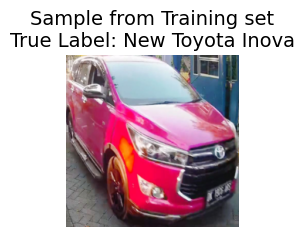

In [13]:
print("Displaying one sample from the training set...")
image, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
show_sample_image(image, label.item(), train_dataset.id_to_class, "Training")

Displaying one sample from the validation set...


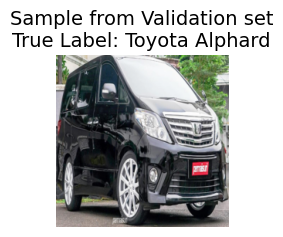

In [14]:
print("Displaying one sample from the validation set...")
image, label = valid_dataset[random.randint(0, len(valid_dataset) - 1)]
show_sample_image(image, label.item(), valid_dataset.id_to_class, "Validation")

Displaying one sample from the testing set...


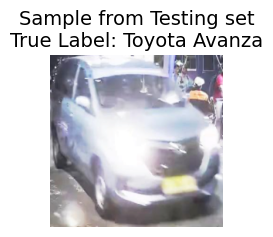

In [15]:
print("Displaying one sample from the testing set...")
image, label = test_dataset[random.randint(0, len(test_dataset) - 1)]
show_sample_image(image, label.item(), test_dataset.id_to_class, "Testing")

## IV.F. Model Training

In [16]:
print("\nStarting training...")
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, log_file_path, best_model_path)
print("Training finished.")


Starting training...


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s, loss=2.44]



Epoch: 01 | Time: 1m 26s
	Train Loss: 2.5626
	 Val. Loss: 2.5756
	 Val. Accuracy: 6.12%
	Best model saved to ../../models/best_vgg_model.pth with validation accuracy: 6.12%



Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=2.36]



Epoch: 02 | Time: 1m 7s
	Train Loss: 2.5192
	 Val. Loss: 2.4605
	 Val. Accuracy: 17.35%
	Best model saved to ../../models/best_vgg_model.pth with validation accuracy: 17.35%



Evaluating: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=2.1]



Epoch: 03 | Time: 1m 5s
	Train Loss: 2.4007
	 Val. Loss: 2.3138
	 Val. Accuracy: 15.31%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=2.58]



Epoch: 04 | Time: 1m 4s
	Train Loss: 2.1499
	 Val. Loss: 2.2917
	 Val. Accuracy: 17.35%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s, loss=2.53]



Epoch: 05 | Time: 1m 4s
	Train Loss: 1.8182
	 Val. Loss: 2.0896
	 Val. Accuracy: 36.73%
	Best model saved to ../../models/best_vgg_model.pth with validation accuracy: 36.73%



Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s, loss=2.75]



Epoch: 06 | Time: 1m 5s
	Train Loss: 1.2419
	 Val. Loss: 2.1330
	 Val. Accuracy: 32.65%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s, loss=4.74]



Epoch: 07 | Time: 1m 4s
	Train Loss: 0.7534
	 Val. Loss: 2.8810
	 Val. Accuracy: 42.86%
	Best model saved to ../../models/best_vgg_model.pth with validation accuracy: 42.86%



Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=3.17]



Epoch: 08 | Time: 1m 5s
	Train Loss: 0.3416
	 Val. Loss: 2.6255
	 Val. Accuracy: 40.82%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=2.36]



Epoch: 09 | Time: 1m 5s
	Train Loss: 0.2016
	 Val. Loss: 3.1757
	 Val. Accuracy: 48.98%
	Best model saved to ../../models/best_vgg_model.pth with validation accuracy: 48.98%



Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s, loss=7.12]



Epoch: 10 | Time: 1m 5s
	Train Loss: 0.1690
	 Val. Loss: 4.8072
	 Val. Accuracy: 42.86%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=6.83]



Epoch: 11 | Time: 1m 5s
	Train Loss: 0.1099
	 Val. Loss: 5.1266
	 Val. Accuracy: 47.96%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=6.71]



Epoch: 12 | Time: 1m 5s
	Train Loss: 0.0672
	 Val. Loss: 4.3938
	 Val. Accuracy: 46.94%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=6.51]



Epoch: 13 | Time: 1m 5s
	Train Loss: 0.0679
	 Val. Loss: 4.5957
	 Val. Accuracy: 47.96%


Evaluating: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=10]



Epoch: 14 | Time: 1m 5s
	Train Loss: 0.0390
	 Val. Loss: 6.1277
	 Val. Accuracy: 46.94%


Evaluating: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s, loss=9.5]



Epoch: 15 | Time: 1m 5s
	Train Loss: 0.0169
	 Val. Loss: 5.6427
	 Val. Accuracy: 51.02%
	Best model saved to ../../models/best_vgg_model.pth with validation accuracy: 51.02%



Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s, loss=6.78]



Epoch: 16 | Time: 1m 5s
	Train Loss: 0.0444
	 Val. Loss: 4.0252
	 Val. Accuracy: 51.02%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=7.05]



Epoch: 17 | Time: 1m 5s
	Train Loss: 0.0162
	 Val. Loss: 5.4472
	 Val. Accuracy: 50.00%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=10.1]



Epoch: 18 | Time: 1m 5s
	Train Loss: 0.0230
	 Val. Loss: 5.3028
	 Val. Accuracy: 48.98%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=9.02]



Epoch: 19 | Time: 1m 5s
	Train Loss: 0.0156
	 Val. Loss: 6.0969
	 Val. Accuracy: 45.92%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=3.99]



Epoch: 20 | Time: 1m 5s
	Train Loss: 0.0474
	 Val. Loss: 3.4024
	 Val. Accuracy: 45.92%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s, loss=5.46]



Epoch: 21 | Time: 1m 4s
	Train Loss: 0.0336
	 Val. Loss: 5.5424
	 Val. Accuracy: 46.94%


Evaluating: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s, loss=7.8]



Epoch: 22 | Time: 1m 4s
	Train Loss: 0.0358
	 Val. Loss: 5.5325
	 Val. Accuracy: 43.88%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=5.23]



Epoch: 23 | Time: 1m 5s
	Train Loss: 0.0318
	 Val. Loss: 4.5098
	 Val. Accuracy: 40.82%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s, loss=3.48]



Epoch: 24 | Time: 1m 5s
	Train Loss: 0.0583
	 Val. Loss: 3.2190
	 Val. Accuracy: 41.84%


Evaluating: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s, loss=8.29]


Epoch: 25 | Time: 1m 5s
	Train Loss: 0.0136
	 Val. Loss: 5.6424
	 Val. Accuracy: 51.02%
Training finished.


## IV.G. Model Testing

In [17]:
print("Starting Evaluation on Test Set...")
best_model = VGG16(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

Starting Evaluation on Test Set...
Loaded best model from: ../../models/best_vgg_model.pth


In [18]:
test_loss, test_accuracy = evaluate(best_model, test_loader, criterion, device)
print("Model Performance")
print(f"Loss on the Test Set: {test_loss:.4f}")
print(f"Accuracy on the Test Set: {test_accuracy:.2f}%")

Evaluating: 100%|████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s, loss=0.122]

Model Performance
Loss on the Test Set: 2.5147
Accuracy on the Test Set: 48.48%


## IV.H. Model Performance Review

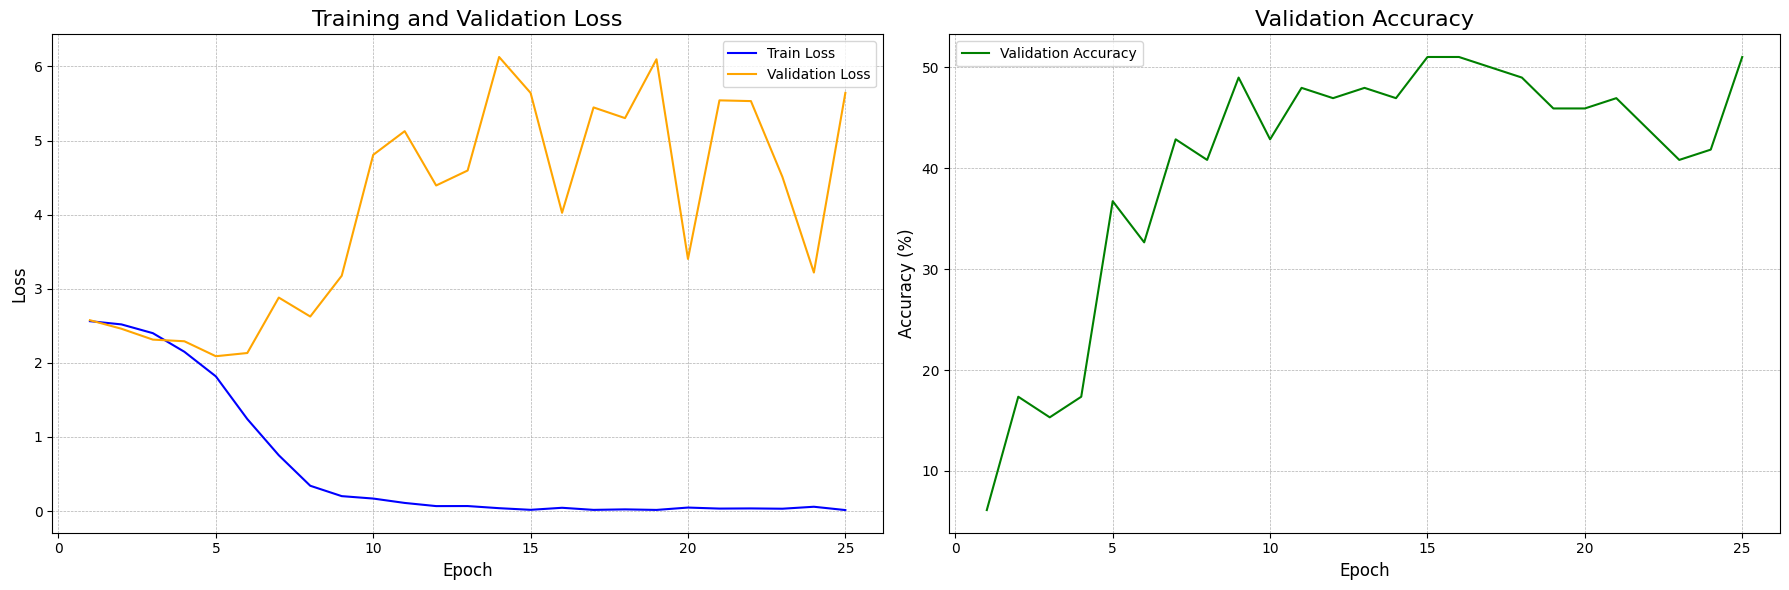

In [19]:
try:
    log_df = pd.read_csv(log_file_path)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(log_df["Epoch"], log_df["Train Loss"], label="Train Loss", color='blue')
    ax1.plot(log_df["Epoch"], log_df["Validation Loss"], label="Validation Loss", color='orange')
    ax1.set_title("Training and Validation Loss", fontsize=16)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.plot(log_df["Epoch"], log_df["Validation Accuracy (%)"], label="Validation Accuracy", color='green')
    ax2.set_title("Validation Accuracy", fontsize=16)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
except FileNotFoundError:
    print(f"Log file not found at: {log_file_path}")
except Exception as error:
    print(f"An error occurred while plotting: {error}")